# Neo4j Aura & GenAI: Getting Started

This notebook will walkthrough a quick demo of how to get your GenAI application started with Neo4j Aura and LangChain / LangGraph. 

We will be using the Movie demo dataset as an example, but your own data may be used as well. You will need to alter the connection information and tools we define.

**In order to run this full notebook, you will need an OpenAI API key.**

The embeddings in this dataset were created using the OpenAI ada002 embedding model, so although you can use another provider's LLM, you will still need to use OpenAI to perform vector similarity search.

## Initial Imports

In [143]:
import os
from typing import Any

from langchain_neo4j import Neo4jGraph
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

from dotenv import load_dotenv

load_dotenv()

True

The LangChain Neo4j module provides an easy to use interface for our Neo4j graph database. 

We can provide the `enhanced_schema=True` argument to get more details about our graph schema.

Our demo Aura instance is a graph of Movie data with embeddings on `Movie` nodes under the property `plotEmbedding`.

The embeddings are created with the OpenAI ada002 embedding model.

Please provide your database credentials in the `.env` file if you'd like to use your own Neo4j database. Otherwise it will default to the Movies demo database.

In [ ]:
graph = Neo4jGraph(
    url=os.getenv("Neo4j_URI", "neo4j+s://demo.neo4jlabs.com"),
    username=os.getenv("Neo4j_USER", "recommendations"),
    password=os.getenv("Neo4j_PASSWORD", "recommendations"),
    database=os.getenv("Neo4j_DATABASE", "recommendations"),
    enhanced_schema=True,
)

We can easily view our graph schema.

Note that the `plotEmbedding` property is not listed here since we typically would only use it for vector similarity search.

In [14]:
print(graph.get_schema)

Node properties:
- **Movie**
  - `url`: STRING Example: "https://themoviedb.org/movie/862"
  - `runtime`: INTEGER Min: 2, Max: 910
  - `revenue`: INTEGER Min: 1, Max: 2787965087
  - `budget`: INTEGER Min: 1, Max: 380000000
  - `imdbRating`: FLOAT Min: 1.6, Max: 9.6
  - `released`: STRING Example: "1995-11-22"
  - `countries`: LIST Min Size: 1, Max Size: 16
  - `languages`: LIST Min Size: 1, Max Size: 19
  - `plot`: STRING Example: "A cowboy doll is profoundly threatened and jealous"
  - `imdbVotes`: INTEGER Min: 13, Max: 1626900
  - `imdbId`: STRING Example: "0114709"
  - `year`: INTEGER Min: 1902, Max: 2016
  - `poster`: STRING Example: "https://image.tmdb.org/t/p/w440_and_h660_face/uXDf"
  - `movieId`: STRING Example: "1"
  - `tmdbId`: STRING Example: "862"
  - `title`: STRING Example: "Toy Story"
- **Genre**
  - `name`: STRING Example: "Adventure"
- **User**
  - `userId`: STRING Example: "1"
  - `name`: STRING Example: "Omar Huffman"
- **Actor**
  - `url`: STRING Example: "https://t

## Explore Our Data

Let's explore our data with some Cypher queries.

In [24]:
top_rated_movies = graph.query("""
MATCH (m:Movie)
WHERE m.imdbRating > 8.5
RETURN m.title as title, m.imdbRating as rating
ORDER BY rating DESC
LIMIT 5
""")

In [26]:
[print(f"{x['title']} --> {x['rating']}") for x in top_rated_movies]

Band of Brothers --> 9.6
Civil War, The --> 9.5
Cosmos --> 9.3
Shawshank Redemption, The --> 9.3
Decalogue, The (Dekalog) --> 9.2


[None, None, None, None, None]

In [28]:
most_active_users = graph.query("""
MATCH (u:User)-[:RATED]->(m:Movie)
RETURN u.name as name, count(m) as numRatings
ORDER BY numRatings DESC
LIMIT 5
""")

In [29]:
[print(f"{x['name']} --> {x['numRatings']}") for x in most_active_users]

Darlene Garcia --> 2391
Robert Brooks --> 1868
Karen Avila --> 1735
Angela Garcia --> 1700
Angela Robertson --> 1610


[None, None, None, None, None]

In [57]:
user_favorite_genres = graph.query("""
MATCH (u:User)-[:RATED]->(m:Movie)-[:IN_GENRE]->(g:Genre)
with u, g.name as genre, count(*) as cnt
order by u, cnt DESC
WITH u, COLLECT({genre: genre, ratings: cnt})[0] AS favorite
RETURN u.name AS name, 
    favorite.genre AS favoriteGenre, 
    favorite.ratings AS ratingCount
ORDER BY ratingCount DESC
LIMIT 10
""")

In [59]:
[print(f"{x['name']} --> {x['favoriteGenre']}: {x['ratingCount']}") for x in user_favorite_genres]

Darlene Garcia --> Drama: 1478
Karen Avila --> Comedy: 892
Larry Boyd --> Drama: 821
Robert Brooks --> Drama: 785
Angela Garcia --> Drama: 770
Rita Owens --> Drama: 618
Angela Robertson --> Drama: 615
Aaron Castro --> Drama: 565
Crystal Spencer --> Drama: 536
Marissa Choi --> Drama: 522


[None, None, None, None, None, None, None, None, None, None]

Now let's take advantage of the vector index on our `Movie` nodes. 

To do this we will need an embedding model to embed our question. We will then use this embedding to find the most similar plot embeddings in our data.

### Using The Vector Index

In [63]:
embedder = OpenAIEmbeddings(model="text-embedding-ada-002")

Here we will simply use the vector index to perform a similarity search.

In [64]:
question = "What are the best movies about space?"
question_embedding = embedder.embed_query(question)

In [74]:
movies_about_space = graph.query("""
CALL db.index.vector.queryNodes('moviePlotsEmbedding', 10, $question_embedding)
YIELD node
RETURN node.title as title, node.imdbRating as rating
ORDER BY rating DESC
LIMIT 5
""", params={"question_embedding": question_embedding})

In [77]:
[print(f"{x['title']} --> {x['rating']}") for x in movies_about_space]

From the Earth to the Moon --> 8.9
Interstellar --> 8.6
2001: A Space Odyssey --> 8.3
For All Mankind --> 8.2
Forbidden Planet --> 7.7


[None, None, None, None, None]

Here we will use the vector index and some Cypher to process the similarity search results. 

Specifically we want to find the actors that are in the found Western films.

In [79]:
question = "What are some famous actors in cowboy western films?"
question_embedding = embedder.embed_query(question)

In [83]:
famous_actors_in_cowboy_western_films = graph.query("""
CALL db.index.vector.queryNodes('moviePlotsEmbedding', 10, $question_embedding)
YIELD node as movie
MATCH (actor)-[:ACTED_IN]->(movie:Movie)
RETURN  actor.name as actor, 
        movie.title as title, 
        movie.imdbRating as rating
ORDER BY rating DESC
LIMIT 10
""", params={"question_embedding": question_embedding})

In [84]:
[print(f"{x['actor']} --> {x['title']} --> {x['rating']}") for x in famous_actors_in_cowboy_western_films]

Clint Eastwood --> Unforgiven --> 8.3
Gene Hackman --> Unforgiven --> 8.3
Morgan Freeman --> Unforgiven --> 8.3
Richard Harris --> Unforgiven --> 8.3
William Holden --> Wild Bunch, The --> 8.0
Edmond O'Brien --> Wild Bunch, The --> 8.0
Ernest Borgnine --> Wild Bunch, The --> 8.0
Robert Ryan --> Wild Bunch, The --> 8.0
Henry Fonda --> My Darling Clementine --> 7.8
Cathy Downs --> My Darling Clementine --> 7.8


[None, None, None, None, None, None, None, None, None, None]

## Building An Agent

Now that we're familiar with our data, let's build a Movie Expert agent that is grounded in our Neo4j graph. 

We'll do this using some of LangChain's agent building functions and OpenAI.

First we need to define our LLM.

In [86]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Tools

Now let's define some tools that our agent can use to answer questions.

We can use the `@tool` decorator provided by LangChain to easily identify tools our agent can use. 

It's important to provide detailed descriptions of what the tool does and what it will return.

In [135]:
@tool
def get_movies_by_plot_similarity(question: str, k: int = 10) -> list[dict[str, Any]]:
    """
    Retrieve information about movies based on vector similarity search. This will retrieve similar movies based on the plot description.

    Parameters
    ----------
    question: str
        The question to answer.
    k: int
        The number of movies to retrieve.

    Returns
    -------
    list[dict[str, Any]]
        A list of dictionaries containing the movie information.
        Each dictionary contains the movile title, actors that starred in the movie, the movie's IMDB rating, and the movie's plot.
    """

    question_embedding = embedder.embed_query(question)
    query = """
    CALL db.index.vector.queryNodes('moviePlotsEmbedding', $k, $question_embedding)
    YIELD node as movie
    MATCH (actor)-[:ACTED_IN]->(movie:Movie)
    RETURN  COLLECT(actor.name) as actors, 
            movie.title as title, 
            movie.imdbRating as rating,
            movie.plot as plot
    ORDER BY rating DESC
    LIMIT $k
    """
    params={"question_embedding": question_embedding, "k": k}
    return graph.query(query, params=params)

In [123]:
@tool
def get_user_favorite_genres_by_name(user_name: str) -> list[dict[str, Any]]:
    """
    Retrieve information about the user's favorite genres. This will retrieve the user's favorite genres and their average rating.
    
    Parameters
    ----------
    user_name: str
        The name of the user to retrieve the favorite genres for.

    Returns
    -------
    list[dict[str, Any]]
        A list of dictionaries containing the user's favorite genres.
        Each dictionary contains the genre name and the average rating for that genre.
    """
    query = """
MATCH (u:User {name: $user_name})-[:RATED]->(m:Movie)-[:IN_GENRE]->(g:Genre)
WHERE m.imdbRating IS NOT NULL
WITH g.name as genre, AVG(m.imdbRating) as avg_rating
ORDER BY avg_rating DESC
RETURN genre, ROUND(avg_rating, 2) as average_rating
LIMIT 10
    """
    params={"user_name": user_name}
    return graph.query(query, params=params)

Let's test out our tools.

In [136]:
res = get_movies_by_plot_similarity("What are the best movies about space?")
print("Results returned:", len(res))
print("First result    :", res[0])

Results returned: 10
First result    : {'actors': ['David Andrews', 'Lane Smith', 'Tom Hanks', 'Nick Searcy'], 'title': 'From the Earth to the Moon', 'rating': 8.9, 'plot': 'Dramatized portrayal of the Apollo manned space program.'}


In [124]:
get_user_favorite_genres_by_name("Rita Owens")

[{'genre': 'Film-Noir', 'average_rating': 7.93},
 {'genre': 'War', 'average_rating': 7.8},
 {'genre': 'Documentary', 'average_rating': 7.76},
 {'genre': 'Mystery', 'average_rating': 7.62},
 {'genre': 'IMAX', 'average_rating': 7.61},
 {'genre': 'Drama', 'average_rating': 7.54},
 {'genre': 'Crime', 'average_rating': 7.54},
 {'genre': 'Animation', 'average_rating': 7.44},
 {'genre': 'Musical', 'average_rating': 7.39},
 {'genre': 'Horror', 'average_rating': 7.37}]

### Agent

Now that we know our tools work, let's create a simple ReAct agent. 

LangGraph provides a function that creates this for us. We just need to provide the LLM and tools it can use.

For more information on this ReAct agent please see the LangGraph documentation: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent

In [133]:
agent = create_react_agent(
    model=llm,
    tools=[get_movies_by_plot_similarity, get_user_favorite_genres_by_name],
)

This is the architecture of our agent. It has two nodes - Reasoning (agent) and Action (tools)

The agent will cycle between these two nodes until it has all the information it needs to answer the question.

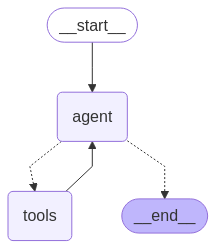

In [134]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

## Asking Questions

We can now ask our agent some questions about movies. Our tools define the scope of answers that this agent can answer. 

If we'd like to expand the scope, we can either provide more tools that address specific use cases or we can provide a generic vector search tool / Cypher generation tool.

In [144]:
def _print_stream(stream):
    """A helper function to print the stream of messages from the agent."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

def ask(question: str):
    """A helper function to ask the agent a question."""
    inputs = {"messages": [("user", question)]}
    _print_stream(agent.stream(inputs, stream_mode="values"))

In [140]:
ask("What are the best movies about space?")

================================ Human Message =================================

What are the best movies about space?
================================== Ai Message ==================================
Tool Calls:
  get_movies_by_plot_similarity (call_OxF1btRQM1i3gFQwGbcuAtmK)
 Call ID: call_OxF1btRQM1i3gFQwGbcuAtmK
  Args:
    question: movies about space
    k: 10
================================= Tool Message =================================
Name: get_movies_by_plot_similarity

[{"actors": ["David Andrews", "Lane Smith", "Tom Hanks", "Nick Searcy"], "title": "From the Earth to the Moon", "rating": 8.9, "plot": "Dramatized portrayal of the Apollo manned space program."}, {"actors": ["Ellen Burstyn", "John Lithgow", "Mackenzie Foy", "Matthew McConaughey"], "title": "Interstellar", "rating": 8.6, "plot": "A team of explorers travel through a wormhole in space in an attempt to ensure humanity's survival."}, {"actors": ["Michael Collins", "Russell Schweickart", "Eugene Cernan", "Jim Love

In [141]:
ask("What are Rita Owens favorite genres?")

================================ Human Message =================================

What are Rita Owens favorite genres?
================================== Ai Message ==================================
Tool Calls:
  get_user_favorite_genres_by_name (call_qKziFOensbs8tauP8r8HHF8Q)
 Call ID: call_qKziFOensbs8tauP8r8HHF8Q
  Args:
    user_name: Rita Owens
================================= Tool Message =================================
Name: get_user_favorite_genres_by_name

[{"genre": "Film-Noir", "average_rating": 7.93}, {"genre": "War", "average_rating": 7.8}, {"genre": "Documentary", "average_rating": 7.76}, {"genre": "Mystery", "average_rating": 7.62}, {"genre": "IMAX", "average_rating": 7.61}, {"genre": "Drama", "average_rating": 7.54}, {"genre": "Crime", "average_rating": 7.54}, {"genre": "Animation", "average_rating": 7.44}, {"genre": "Musical", "average_rating": 7.39}, {"genre": "Horror", "average_rating": 7.37}]
================================== Ai Message ========================